# Read data from Mongodb

In [0]:
database = 'MSDS697'
collection = 'Tweets'
user_name = 'qliu46'
password = 'Tina0726'
address = 'msds697.us6ly.mongodb.net'#grad address from MongoDB
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"
df = spark.read.format("mongo").option("uri",connection_string).load().dropna(how='any')

In [0]:
df.show(5)

+--------------------+---------+--------------------+-------------------+-------------------+----------+-----------+-----------+-------------+--------------------+
 Adj Close| Volumn| _id| created_date| date|like_count|quote_count|reply_count|retweet_count| text|
+--------------------+---------+--------------------+-------------------+-------------------+----------+-----------+-----------+-------------+--------------------+
0.002375999931246...| 84321565|{62252dde85be0052...|2020-01-21 00:00:00|2020-01-21 00:00:00| 0| 0| 0| 4|RT @unlockbc: Blo...|
0.002375999931246...| 84321565|{62252dde85be0052...|2020-01-21 00:00:00|2020-01-21 00:00:00| 0| 0| 0| 4|RT @unlockbc: Blo...|
0.002490000100806...|117752841|{62252dde85be0052...|2020-01-17 00:00:00|2020-01-17 00:00:00| 2| 0| 0| 3|A must read, Why ...|
0.002490000100806...|117752841|{62252dde85be0052...|2020-01-17 00:00:00|2020-01-17 00:00:00| 0| 0| 0| 3|RT @stephenajulu:...|
0.002256999956443906| 82421399|{62252dde85be0052...|2020-01-25 00:00:00|2020-01-25 00:00:00| 0| 0| 0| 0|#DeutscheBank Pre...|
+--------------------+---------+--------------------+-------------------+-------------------+----------+-----------+-----------+-------------+--------------------+
only showing top 5 rows

# General data preprocess

## Get daily average features and daily price

In [0]:
%%time
# Remove columns _id, created_date, text, Volumn
# Times 1000 to close price to avoid overflow
df_price = df.drop("_id", "created_date", "text", "Volumn").withColumnRenamed("Adj Close", "label")
df_price = df_price.withColumn('label_1000', df_price['label']*1000).drop("label").withColumnRenamed("label_1000", "label")
df_price.show(5)

+-------------------+----------+-----------+-----------+-------------+------------------+
 date|like_count|quote_count|reply_count|retweet_count| label|
+-------------------+----------+-----------+-----------+-------------+------------------+
2020-01-21 00:00:00| 0| 0| 0| 4|2.3759999312460423|
2020-01-21 00:00:00| 0| 0| 0| 4|2.3759999312460423|
2020-01-17 00:00:00| 2| 0| 0| 3|2.4900001008063555|
2020-01-17 00:00:00| 0| 0| 0| 3|2.4900001008063555|
2020-01-25 00:00:00| 0| 0| 0| 0| 2.256999956443906|
+-------------------+----------+-----------+-----------+-------------+------------------+
only showing top 5 rows

CPU times: user 54 ms, sys: 29.5 ms, total: 83.5 ms
Wall time: 18.1 s

In [0]:
%%time
# group by date and get average features
# remove date after aggregation
df_daily_price = df_price.groupBy("date").avg()\
                        .withColumnRenamed("avg(like_count)", "avg_like_count")\
                        .withColumnRenamed("avg(quote_count)", "avg_quote_count")\
                        .withColumnRenamed("avg(reply_count)", "avg_reply_count")\
                        .withColumnRenamed("avg(retweet_count)", "avg_retweet_count")\
                        .withColumnRenamed("avg(label)", "label")\
                        .orderBy("date").drop("date")
df_daily_price.show(5)

+-------------------+-------------------+--------------------+-------------------+------------------+
 avg_like_count| avg_quote_count| avg_reply_count| avg_retweet_count| label|
+-------------------+-------------------+--------------------+-------------------+------------------+
 0.8579234972677595| 0.0| 0.09289617486338798| 6.3224043715847| 2.03300011344254|
 0.521505376344086|0.03225806451612903| 0.05913978494623656| 2.849462365591398|2.0089999306946993|
0.46994535519125685|0.01092896174863388| 0.07650273224043716| 22.19672131147541| 2.145000034943223|
0.20441988950276244| 0.0|0.022099447513812154| 1.160220994475138|2.2410000674426556|
 0.3891891891891892| 0.0| 0.04864864864864865|0.31351351351351353|2.4190000258386135|
+-------------------+-------------------+--------------------+-------------------+------------------+
only showing top 5 rows

CPU times: user 22.8 ms, sys: 7.72 ms, total: 30.6 ms
Wall time: 5.89 s

In [0]:
%%time
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(outputCol="features", 
                     inputCols=df_daily_price.columns[1:]) #except the first col
avg_features = va.transform(df_daily_price).select("features", "label")

CPU times: user 1.67 ms, sys: 4.01 ms, total: 5.68 ms
Wall time: 67.3 ms

In [0]:
avg_features.show(5)

+--------------------+------------------+
 features| label|
+--------------------+------------------+
[0.0,0.0928961748...| 2.03300011344254|
[0.03225806451612...|2.0089999306946993|
[0.01092896174863...| 2.145000034943223|
[0.0,0.0220994475...|2.2410000674426556|
[0.0,0.0486486486...|2.4190000258386135|
+--------------------+------------------+
only showing top 5 rows

# EDA

## Use summary to see the brief data distribution

In [0]:
df_daily_price.summary().show()

+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
summary| avg_like_count| avg_quote_count| avg_reply_count| avg_retweet_count| label|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
 count| 130| 130| 130| 130| 130|
 mean| 0.5560234422777686|0.015923769913273437| 0.08008327730929382| 3.0804852025071923| 2.2749846192220082|
 stddev| 0.600160592361296|0.035063795596012796| 0.11510793339049628| 3.647230033316622|0.36541576185041796|
 min|0.05291005291005291| 0.0| 0.0|0.16901408450704225| 1.5369999455288053|
 25%| 0.2568306010928962| 0.0|0.026737967914438502| 0.9735449735449735| 1.990000018849969|
 50%| 0.3825136612021858|0.005555555555555556| 0.0582010582010582| 1.7765957446808511| 2.3240000009536743|
 75%| 0.5904255319148937|0.016666666666666666| 0.09239130434782608| 3.5274725274725274| 2.4939998984336853|
 max| 4.767195767195767| 0.33513513513513515| 0.9459459459459459| 22.19672131147541| 3.2319999299943447|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+

The mean of the retweet per day is less than 1, the 75% it about 3.5, but the max is 22! We may wanna do some transformation on it later.

Other features also show some extreme values, can consider to operate on them as well.

## scatter plot of features and stock close price

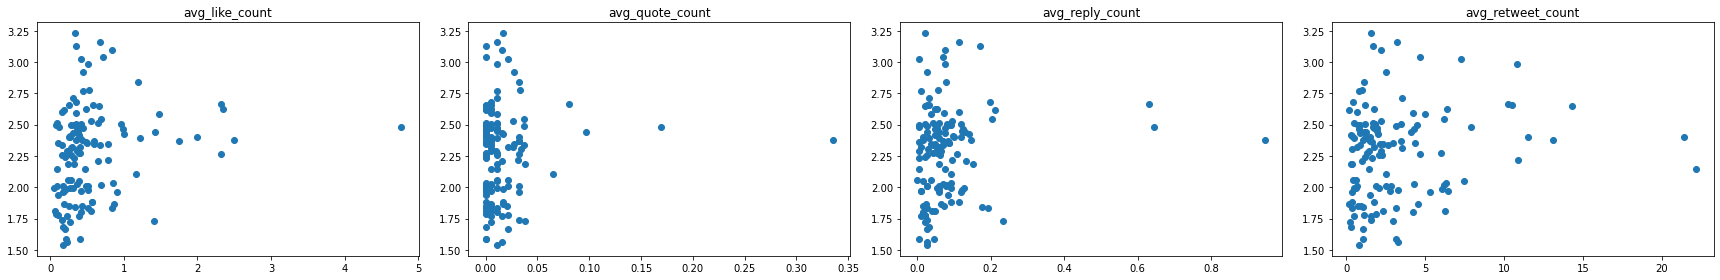

In [0]:
import matplotlib.pyplot as plt
price_list=df_daily_price.toPandas()["label"].values.tolist()
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
for i, col in enumerate(df_daily_price.columns[:-1]):
    col_list=df_daily_price.toPandas()[col].values.tolist()
    axes[i].scatter(col_list, price_list)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

several points are abnormal, we can try log / normalization / truncate later

## Divide the dataset into training and vaildation sets.

In [0]:
#Divide the dataset into training and vaildation sets.
splits = avg_features.randomSplit([0.8, 0.2])

#cache() : the algorithm is interative and training and data sets are going to be reused many times.
feat_train = splits[0].cache()
feat_valid = splits[1].cache()

# Random Forest 

## Train random forest regression model

In [0]:
from pyspark.ml.regression import RandomForestRegressor

In [0]:
%%time
# train the model
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_model = rf.fit(feat_train)

CPU times: user 31.2 ms, sys: 5.16 ms, total: 36.4 ms
Wall time: 4.31 s

## Evaluate random forest regression model

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
# Make predictions.
rf_predictions = rf_model.transform(feat_valid)

# Select (prediction, true label) and compute test score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

evaluator.evaluate(rf_predictions)

Out[22]: 0.9308831551122357

In [0]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
evaluator.evaluate(rf_predictions)

Out[23]: 0.00940527872603869

## Try cross-validation

In [0]:
%%time
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rf2 = RandomForestRegressor(featuresCol="features", labelCol="label")

paramGrid = ParamGridBuilder() \
    .addGrid(rf2.maxDepth, [5, 10])\
    .addGrid(rf2.numTrees, [10, 50])\
    .build()

cv = CrossValidator(estimator=rf2,
                    evaluator=evaluator, 
                    numFolds=5,
                    estimatorParamMaps=paramGrid)
cv_model = cv.fit(feat_train)

In [0]:
cv_predictions = cv_model.transform(feat_valid)
evaluator.evaluate(cv_predictions)

Out[26]: 0.9390575816242813

In [0]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
evaluator.evaluate(rf_predictions)

Out[27]: 0.00940527872603869

The R square is too high, which violates our intuition. It might because we dont have a large dataset & have some abnormal data, let's do more exploratory processing

## Log Transformation on features

In [0]:
# smooth and then take log to compress the data, making them dense
from pyspark.sql.functions import log
log_df = df_daily_price
for col in df_daily_price.columns[:-1]:
    log_df = log_df.withColumn("log_"+col, log(df_daily_price[col]+1)).drop(col)
log_df.show(5)

+------------------+-------------------+--------------------+--------------------+---------------------+
 label| log_avg_like_count| log_avg_quote_count| log_avg_reply_count|log_avg_retweet_count|
+------------------+-------------------+--------------------+--------------------+---------------------+
 2.03300011344254| 0.6194594647687861| 0.0| 0.08883121370661583| 1.990938740103536|
2.0089999306946993|0.41970022393003636| 0.03174869831458027| 0.05745705502478721| 1.3479334932474445|
 2.145000034943223| 0.3852252267604182|0.010869672236903891| 0.07371757589656765| 3.144010945904027|
2.2410000674426556| 0.1859980315232633| 0.0|0.021858793812499017| 0.77021052871954|
2.4190000258386135| 0.328720259816895| 0.0| 0.04750233398500326| 0.27270561826222356|
+------------------+-------------------+--------------------+--------------------+---------------------+
only showing top 5 rows

In [0]:
# see distribution after log transformation
log_df.describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+---------------------+
summary| label| log_avg_like_count| log_avg_quote_count|log_avg_reply_count|log_avg_retweet_count|
+-------+-------------------+--------------------+--------------------+-------------------+---------------------+
 count| 130| 130| 130| 130| 130|
 mean| 2.2749846192220082| 0.39607517518177365|0.015281646893124274|0.07275131492905054| 1.1575285458720275|
 stddev|0.36541576185041796| 0.27600957446886026|0.031229619911175222|0.08712673293918649| 0.6568321256564281|
 min| 1.5369999455288053|0.051557809664850116| 0.0| 0.0| 0.1561607307552825|
 max| 3.2319999299943447| 1.752185960163547| 0.2890325115496525| 0.665748206371831| 3.144010945904027|
+-------+-------------------+--------------------+--------------------+-------------------+---------------------+

In [0]:
va = VectorAssembler(outputCol="features", 
                     inputCols=log_df.columns[1:]) #except the first col
log_avg_features = va.transform(log_df).select("features", "label")

In [0]:
#Divide the dataset into training and vaildation sets.
splits = log_avg_features.randomSplit([0.8, 0.2])
#cache() : the algorithm is interative and training and data sets are going to be reused many times.
log_feat_train = splits[0].cache()
log_feat_valid = splits[1].cache()

In [0]:
%%time
# train the model
rf_log = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_log_model = rf_log.fit(log_feat_train)

CPU times: user 126 ms, sys: 56.1 ms, total: 182 ms
Wall time: 36.6 s

In [0]:
# Make predictions.
rf_log_predictions = rf_log_model.transform(log_feat_valid)

# Select (prediction, true label) and compute test score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

evaluator.evaluate(rf_log_predictions)

Out[18]: -0.16013148673414235

In [0]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
evaluator.evaluate(rf_log_predictions)

Out[19]: 0.11553937308261054

After Log, the R square becomes negative, MSE is big

## Truncate 95% on feature

In [0]:
# function from https://stackoverflow.com/questions/55257351/clip-a-spark-dataframe-columns-by-its-95-and-5-values
from pyspark.sql.functions import col, when

def clip(df, cols, lower=0.05, upper=0.95, relativeError=0.001):
    if not isinstance(cols, (list, tuple)):
        cols = [cols]
    # Create dictionary {column-name: [lower-quantile, upper-quantile]}
    quantiles = {
        c: (when(col(c) < lower, lower)        # Below lower quantile
                .when(col(c) > upper, upper)   # Above upper quantile
                .otherwise(col(c))             # Between quantiles
                .alias(c))   
        for c, (lower, upper) in 
        # Compute array of quantiles
        zip(cols, df.stat.approxQuantile(cols, [lower, upper], relativeError))
    }

    return df.select([quantiles.get(c, col(c)) for c in df.columns])

In [0]:
truncate_df = clip(df_daily_price, df_daily_price.columns[1:])
truncate_df.show(5)

+-------------------+-------------------+--------------------+-------------------+------------------+
 avg_like_count| avg_quote_count| avg_reply_count| avg_retweet_count| label|
+-------------------+-------------------+--------------------+-------------------+------------------+
 0.8579234972677595| 0.0| 0.09289617486338798| 6.3224043715847| 2.03300011344254|
 0.521505376344086|0.03225806451612903| 0.05913978494623656| 2.849462365591398|2.0089999306946993|
0.46994535519125685|0.01092896174863388| 0.07650273224043716| 10.80952380952381| 2.145000034943223|
0.20441988950276244| 0.0|0.022099447513812154| 1.160220994475138|2.2410000674426556|
 0.3891891891891892| 0.0| 0.04864864864864865|0.33152173913043476|2.4190000258386135|
+-------------------+-------------------+--------------------+-------------------+------------------+
only showing top 5 rows

In [0]:
# see the new distribution
truncate_df.describe().show()

+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
summary| avg_like_count| avg_quote_count| avg_reply_count| avg_retweet_count| label|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+
 count| 130| 130| 130| 130| 130|
 mean| 0.5560234422777686|0.011631564470172856| 0.06718653902724202| 2.864268846755536| 2.274561535495405|
 stddev| 0.600160592361296|0.012451178268118852|0.051447430037013415| 2.7908181556867775|0.34241865193788235|
 min|0.05291005291005291| 0.0|0.005376344086021506|0.33152173913043476| 1.7229999648407102|
 max| 4.767195767195767| 0.03783783783783784| 0.19786096256684493| 10.80952380952381| 2.985999919474125|
+-------+-------------------+--------------------+--------------------+-------------------+-------------------+

In [0]:
va = VectorAssembler(outputCol="features", 
                     inputCols=truncate_df.columns[1:]) #except the first col
truncate_avg_features = va.transform(truncate_df).select("features", "label")

In [0]:
#Divide the dataset into training and vaildation sets.
splits = truncate_avg_features.randomSplit([0.8, 0.2])
#cache() : the algorithm is interative and training and data sets are going to be reused many times.
truncate_feat_train = splits[0].cache()
truncate_feat_valid = splits[1].cache()

In [0]:
%%time
# train the model
rf_truncate = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_truncate_model = rf_truncate.fit(truncate_feat_train)

CPU times: user 78.4 ms, sys: 36.8 ms, total: 115 ms
Wall time: 25.1 s

In [0]:
# Make predictions.
rf_truncate_predictions = rf_truncate_model.transform(truncate_feat_valid)

# Select (prediction, true label) and compute test score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

evaluator.evaluate(rf_truncate_predictions)

Out[45]: 0.9251318974594803

In [0]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")
evaluator.evaluate(rf_truncate_predictions)

Out[46]: 0.007389090400452941

# Linear regression 

In [0]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Train linear regression model

In [0]:
%%time
# train the model
lr_before = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_before_model = lr_before.fit(feat_train)

CPU times: user 24.9 ms, sys: 12.3 ms, total: 37.3 ms
Wall time: 5.18 s

## Evaluate Linear regression model

In [0]:
# Make predictions.
lr_before_predictions = lr_before_model.transform(feat_valid)

# Select (prediction, true label) and compute test score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

evaluator.evaluate(lr_before_predictions)

Out[60]: 0.5115248609799059

In [0]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")

evaluator.evaluate(lr_before_predictions)

Out[61]: 0.055334456914949356

## Train linear model on standardize features

In [0]:
%%time
scaler = StandardScaler(withStd=True, withMean=True)
scaler.setInputCol("features").setOutputCol("features_scaled")
sc_model = scaler.fit(feat_train)
scaled_train = sc_model.transform(feat_train).drop("features").withColumnRenamed("features_scaled", "features")
scaled_valid = sc_model.transform(feat_valid).drop("features").withColumnRenamed("features_scaled", "features")

CPU times: user 24.5 ms, sys: 2 ms, total: 26.5 ms
Wall time: 849 ms

In [0]:
scaled_train.show(5)

+------------------+--------------------+
 label| features|
+------------------+--------------------+
2.0089999306946993|[0.46537583872370...|
 2.145000034943223|[-0.1422488004826...|
2.2410000674426556|[-0.4535936569355...|
2.4190000258386135|[-0.4535936569355...|
 2.432999899610877|[0.00100295527887...|
+------------------+--------------------+
only showing top 5 rows

In [0]:
%%time
# train the model
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(scaled_train)

CPU times: user 13.4 ms, sys: 1.33 ms, total: 14.8 ms
Wall time: 1.13 s

In [0]:
# Make predictions.
lr_predictions = lr_model.transform(scaled_valid)

# Select (prediction, true label) and compute test score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")

evaluator.evaluate(lr_predictions)

Out[65]: 0.5115248609799116

In [0]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse")

evaluator.evaluate(lr_predictions)

Out[66]: 0.05533445691494869